# Credit Card Analysis Assessment

### Step 1: Initialize PySpark Session
Set up a PySpark session to enable distributed data processing.

### Step 2: Load Data from JSON File
Read the credit card transaction data from a JSON file into a PySpark DataFrame.

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("JSON Reader").getOrCreate()

df = spark.read.json("data/cc_sample_transaction.json")

your 131072x1 screen size is bogus. expect trouble
25/03/20 08:38:27 WARN Utils: Your hostname, TonyOS resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/03/20 08:38:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/20 08:38:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Step 3a: Parsing Personal Details  
Define a schema to parse the personal details from the dataset. This helps PySpark understand the structure of the data when extracting nested fields.

In [4]:
from pyspark.sql.functions import col, from_json, split
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, TimestampType

personal_detail_schema = StructType([
    StructField("person_name", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("address", StringType(), True),
    StructField("lat", StringType(), True),
    StructField("long", StringType(), True),
    StructField("city_pop", StringType(), True),
    StructField("job", StringType(), True),
    StructField("dob", StringType(), True)
])

### Step 3b: Name Derivation  

In this step, we aim to parse the `personal_detail` field as a structured object and derive the cardholder's first and last names from the `person_name` field.  

#### Key Considerations:  
- **Parsing `personal_detail` as a Struct**:  
  Use the previously defined schema to extract the nested fields, including `person_name`.  

- **Splitting `person_name`**:  
  Initially, it seemed that names were separated by a simple space. However, further analysis revealed that names could be split by various delimiters.  

- **Handling Dirty Data**:  
  Some entries contain dirty data, such as the addition of "NOOOO" to names.  
  - To handle this, use a regex pattern to split the name based on non-alphabetic characters.  
  - Extract the first and second items from the split results to derive the first and last names.  

#### Example:  
- Raw `person_name`: `"John@Doe NOOOOO"`  
- Regex Split Result: `["John", "Doe", "NOOOO"]`  
- Derived Names:  
  - **First Name**: `"John"`  
  - **Last Name**: `"Doe"`  

The rest of the transformation is fairly straightforward, using PySpark’s `split()` function with the regex pattern.  

In [5]:
df = df.withColumn("personal_detail", from_json("personal_detail", personal_detail_schema))

df = df.withColumn("first", split(col("personal_detail.person_name"), "[^A-Za-z]+").getItem(0))
df = df.withColumn("last", split(col("personal_detail.person_name"), "[^A-Za-z]+").getItem(1))

df = df.withColumn("gender", col("personal_detail.gender"))
df = df.withColumn("city_pop", col("personal_detail.city_pop"))
df = df.withColumn("job", col("personal_detail.job"))
df = df.withColumn("dob", col("personal_detail.dob"))
df = df.withColumn("lat", col("personal_detail.lat"))
df = df.withColumn("long", col("personal_detail.long"))

### Step 3c: Parsing Address into Street, City, State, and ZIP  

Just like `person_name`, the `address` field is a nested structure that needs to be parsed into its individual components: `street`, `city`, `state`, and `zip`.

In [6]:
address_schema = StructType([
    StructField("street", StringType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("zip", StringType(), True)
])

### Step 3d: Extract Address Details  

After defining the schema, extract the individual components from the `address` struct. This step simplifies queries and transformations that involve location-based insights.

- Use the `from_json()` function to parse the `address` field according to the `address_schema`.  
- Access the nested fields directly, making it easier to filter, group, or analyze data by location.  

In [7]:
df = df.withColumn("address", from_json(col("personal_detail.address"), address_schema))

df = df.withColumn("street", col("address.street"))
df = df.withColumn("city", col("address.city"))
df = df.withColumn("state", col("address.state"))
df = df.withColumn("zip", col("address.zip"))

### Step 3e: Convert Timestamps to Human-Readable Format in UTC+8  

The dataset contains two types of epoch timestamps:  
- **13-digit timestamps**: Represent milliseconds.  
- **16-digit timestamps**: Represent microseconds.  

#### Key Steps:  
- **Length Check**:  
  Use an `if` statement to check the length of the timestamp and divide accordingly:  
  - If the length is **13 digits**, divide by `1000` to convert milliseconds to seconds.  
  - If the length is **16 digits**, divide by `1,000,000` to convert microseconds to seconds.  

- **Timezone Handling**:  
  Initially, the assumption was that the timestamps were in UTC, leading to the use of `from_utc_timestamp()` to convert them to UTC+8.  
  However, after further investigation, the timestamps were found to already be in local time (UTC+8), so no additional timezone conversion is required.

In [8]:
from pyspark.sql.functions import from_utc_timestamp, from_unixtime, col, date_format, expr

df = df.withColumn("trans_date_trans_time", date_format(from_utc_timestamp(col("trans_date_trans_time"), "Asia/Singapore"), "yyyy-MM-dd HH:mm"))

df = df.withColumn(
    "merch_last_update_time",
    date_format(
        from_unixtime(expr("merch_last_update_time / (IF(LENGTH(merch_last_update_time) = 16, 1000000, 1000))")),
        "yyyy-MM-dd HH:mm"
    )
)

df = df.withColumn(
    "merch_eff_time",
    date_format(
        from_unixtime(expr("merch_eff_time / (IF(LENGTH(merch_eff_time) = 16, 1000000, 1000))")),
        "yyyy-MM-dd HH:mm"
    )
)

### Step 3f: Drop Unnecessary Columns  

After extracting the nested fields from the struct columns, the original struct columns are no longer needed — they served only as placeholders for the raw data.  

#### Key Steps:  
- Identify and drop the original struct columns, such as `personal_detail` and `address`, after parsing their contents.  
- This step helps reduce memory usage and makes the DataFrame cleaner, containing only relevant fields for further analysis.

In [9]:
df = df.drop("personal_detail", "address")

### Step 4a: Check for Data Inconsistencies  

This step ensures data quality by identifying and handling various inconsistencies in the dataset.  

#### Key Checks:  

- **Missing or Null Values**:  
  Identify rows with missing or null values in key fields to avoid incomplete data affecting the analysis.  

- **Inconsistent Formats**:  
  Verify that fields follow the expected format, such as proper date formats, valid numeric values, and correctly structured strings.  

- **Categorical Values**:  
  Check categorical fields for unexpected or inconsistent values. For example, verify that `gender` only contains valid options like "M" and "F".

- **Duplicate Rows**:  
  Identify and handle duplicate records that could skew results or lead to redundant processing.  

### Step 4b: Missing or Null Values Check

The following code dynamically checks for missing values and common placeholders across multiple columns. Let’s break it down:  

1. **Define Columns to Check**:  
   - `columns_to_check` contains the list of columns that need to be checked for inconsistencies.

2. **Build the Filter Condition**:  
   - A `condition` is dynamically built by iterating over each column in `columns_to_check`.  
   - For each column, the code checks for:  
     - **Null Values**: `col(c).isNull()`  
     - **Empty Strings**: `(col(c) == "")`  
     - **Common Placeholders**: `upper(col(c))` is used to check for `"N/A"`, `"NA"`, and `"None"` in a case-insensitive manner.  
   - Multiple conditions are combined using the `|` (OR) operator, ensuring that if any condition is met, the row will be flagged as dirty.  

3. **Filter Dirty Rows**:  
   - `df.filter(condition)` filters out rows that match any of the conditions defined earlier, resulting in a `dirty_rows` DataFrame containing only the problematic rows.  

4. **Count Dirty Rows**:  
   - `dirty_rows.count()` counts the number of rows that failed the check, giving a quick overview of data cleanliness.  

5. **Print Results**:  
   - Finally, a message is printed showing the total number of rows with missing or invalid values.  

In [10]:
from pyspark.sql.functions import col, upper

columns_to_check = ["first", "last", "cc_num", "amt", "trans_date_trans_time", "merch_last_update_time", "merch_eff_time"]

condition = None
for c in columns_to_check:
    col_condition = (
        col(c).isNull() | # Check for null values
        (col(c) == "") | # Check for empty strings
        (upper(col(c)) == "N/A") | # Check for "N/A" (case-insensitive)
        (upper(col(c)) == "NA") | # Check for "NA" (case-insensitive)
        (upper(col(c)) == "NONE") # Check for "None" (case-insensitive)
    )
    condition = col_condition if condition is None else condition | col_condition

dirty_rows = df.filter(condition)
print(f"There is {dirty_rows.count()} rows with empty values.")


There is 0 rows with empty values.


### Step 4c: Time Format Validation:  

The following code ensures that all time-related columns follow the expected format: **"yyyy-MM-dd HH:mm"**. Let’s break it down step-by-step:  

1. **Define Time Columns**:  
   - `time_columns` contains a list of columns that represent timestamps, such as transaction times and merchant update times.  

2. **Initialize Condition**:  
   - `condition` is initialized as `None` and will later be built dynamically to check all time columns.  

3. **Define Time Format Regex**:  
   - `time_format_regex` is a regular expression that matches the desired timestamp format:  
     - `\d{4}`: Matches the 4-digit year.  
     - `\d{2}`: Matches the 2-digit month, day, hour, and minute.  
     - `^\d{4}-\d{2}-\d{2} \d{2}:\d{2}$`: Ensures the entire string follows the "yyyy-MM-dd HH:mm" format, with no extra characters before or after.  

4. **Build the Filter Condition**:  
   - The code loops through each column in `time_columns`.  
   - `col(c).rlike(time_format_regex)` checks if the column value matches the expected format.  
   - `~` negates the result, meaning rows that **don’t** match the format are flagged as invalid.  
   - Each column’s condition is combined using the `|` (OR) operator so that if any column has an invalid format, the row is flagged.  

5. **Filter Invalid Rows**:  
   - `df.filter(condition)` filters out rows where any time column has an invalid format, creating a DataFrame `invalid_time_rows` containing only those problematic rows.  

6. **Count and Print Results**:  
   - `invalid_time_rows.count()` counts the number of invalid rows, giving a quick summary of time format inconsistencies.

In [11]:
time_columns = ["trans_date_trans_time", "merch_last_update_time", "merch_eff_time"]

condition = None

time_format_regex = r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}$'

for c in time_columns:
    col_condition = ~col(c).rlike(time_format_regex)
    condition = col_condition if condition is None else condition | col_condition
    
invalid_time_rows = df.filter(condition)

print(f"There is {invalid_time_rows.count()} invalid time rows.")

There is 0 invalid time rows.


### Step 4d: Categorical Value Validation:  

The following code checks if the **"gender"** column contains only valid values: **"M"** or **"F"**. Let’s break it down step-by-step:  

1. **Filter Invalid Gender Rows**:  
   - `col("gender").isin(["M", "F"])` checks if each value in the "gender" column is either **"M"** or **"F"**.  
   - `~` negates the condition, meaning rows that **don’t** match these valid values are flagged as invalid.  
   - `df.filter()` filters out rows where the "gender" column contains invalid entries, creating a DataFrame `invalid_gender_rows` with only those problematic rows.  

2. **Count and Print Results**:  
   - `invalid_gender_rows.count()` counts the number of invalid rows and prints the total, giving a quick summary of gender-related inconsistencies.  

In [12]:
invalid_gender_rows = df.filter(~col("gender").isin(["M", "F"]))

print(f"There is {invalid_gender_rows.count()} rows with invalid gender.")

There is 0 rows with invalid gender.


### Step 5: Hashing  

In this step, **SHA hashing** is applied to sensitive data for privacy protection. Let’s break down the reasoning and process:  

#### Why Use SHA Hashing?  
- **One-Way Encryption**: SHA (Secure Hash Algorithm) is a one-way cryptographic function, meaning the original value can’t be retrieved from the hashed result.  
- **Data Privacy**: Sensitive information (e.g., credit card numbers or personal details) is obfuscated, ensuring privacy while still allowing data analysis.  
- **Record Matching**: Hashed values enable record matching across datasets without exposing the original values.  
- **Integrity Check**: Helps verify data integrity by ensuring that the same input consistently produces the same hashed value.  

#### Implementation:  
- Choose the appropriate SHA variant (e.g., SHA-256 or SHA-512) based on the required security level.  
- Apply the hashing function to sensitive fields like credit card numbers or personal identifiers.  
- Store the hashed values in new columns or replace the original columns, depending on the use case.  

In [ ]:
from pyspark.sql.functions import sha2

pii_columns = ["cc_num", "first", "last", "street", "city", "state", "zip"]
for col in pii_columns:
    df = df.withColumn(col, sha2(col, 256))

### Step 6a: Fraud Detection Analysis  

In this step, the focus is on identifying and analyzing fraudulent transactions within the dataset. 

#### Fraud Identification:  
- A **fraud flag** column is typically used, where values like `1` indicate fraud, and `0` indicates legitimate transactions.  
- Count the total number of fraud cases and compare it against the overall transaction count to determine the fraud rate.  

#### Key Insight:  
- In this dataset:  
  - The number of fraud cases is **7,506**.  
  - The total number of transactions is **1,296,675**.  
  - The fraud rate is approximately **0.579%**, indicating that fraud cases are relatively rare.


### Step 6b: Fraud Detection Analysis — Extracting Fraud Cases  

In this step, we aim to extract fraudulent transactions from the dataset and convert them into a Pandas DataFrame for further analysis and visualization.

We filter the original PySpark DataFrame `df` using the `filter()` method to select only the rows where the `is_fraud` column equals **1**.

The filtered results are stored in `fraud_df`. 

Since PySpark DataFrames are optimized for distributed processing and are not directly compatible with Pandas, we use `collect()` to gather all rows into memory as a list of PySpark Row objects, stored in `rows`. 

Each Row object is then converted into a Python dictionary with `row.asDict()` to ensure compatibility with Pandas. Finally, we create a Pandas DataFrame using `pd.DataFrame()` from this list of dictionaries, resulting in `fraud_df_pandas` — a DataFrame containing only fraudulent transactions.

In [18]:
fraud_df = df.filter(df["is_fraud"] == 1)

import pandas as pd
rows = fraud_df.collect()

fraud_df_pandas = pd.DataFrame([row.asDict() for row in rows])

### Step 6c: Fraud Distribution Across Categories  

In this step, we visualize the distribution of fraudulent transactions across different categories to identify which areas are most affected by fraud.  

First, we import `matplotlib.pyplot` and `seaborn` — popular libraries for data visualization. We set the figure size to **10x6** to ensure the plot is clear and readable.  

Using `sns.countplot()`, we create a horizontal bar plot where each bar represents a **category**, and its length shows the **number of fraudulent transactions** in that category.  

- The `order` parameter sorts the categories by the count of fraudulent transactions in **descending order**, making it easier to spot the most affected categories.  
- The `hue` parameter ensures each category has a unique color, and the `palette='coolwarm'` applies a visually appealing color gradient.  

Finally, we add a title, axis labels, and use `plt.show()` to display the plot.

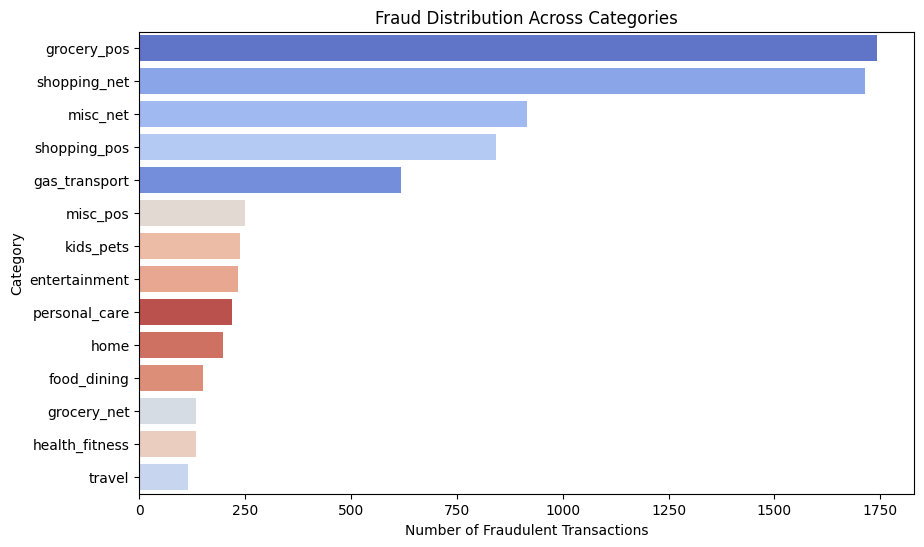

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(
    data=fraud_df_pandas,
    y='category',
    order=fraud_df_pandas['category'].value_counts().index,
    hue='category',
    palette='coolwarm'
)
plt.title('Fraud Distribution Across Categories')
plt.xlabel('Number of Fraudulent Transactions')
plt.ylabel('Category')
plt.show()

### Step 6d: Transaction Time Patterns for Fraud Cases (Hourly)  

1. **Convert Transaction Time:**  
   - The `trans_date_trans_time` column is converted into a datetime format using `pd.to_datetime()` to allow easy manipulation of date and time components.  

2. **Extract Hour of Transaction:**  
   - A new column `hour` is created by extracting the hour component from `trans_date_trans_time` using `.dt.hour`. This gives us a value between **0** and **23** representing the hour of the day each fraudulent transaction occurred.  

3. **Plot the Distribution:**  
   - A histogram is plotted to visualize the frequency of fraudulent transactions across different hours of the day.  
   - `sns.histplot()` creates the histogram, with `bins=24` to represent each hour distinctly.  
   - `kde=True` adds a smooth curve to visualize the density of fraudulent transactions.  
   - The `color='crimson'` makes the bars visually stand out, and the plot is titled appropriately.  

4. **Interpretation:**  
   - This plot reveals whether fraud tends to spike at specific hours of the day.

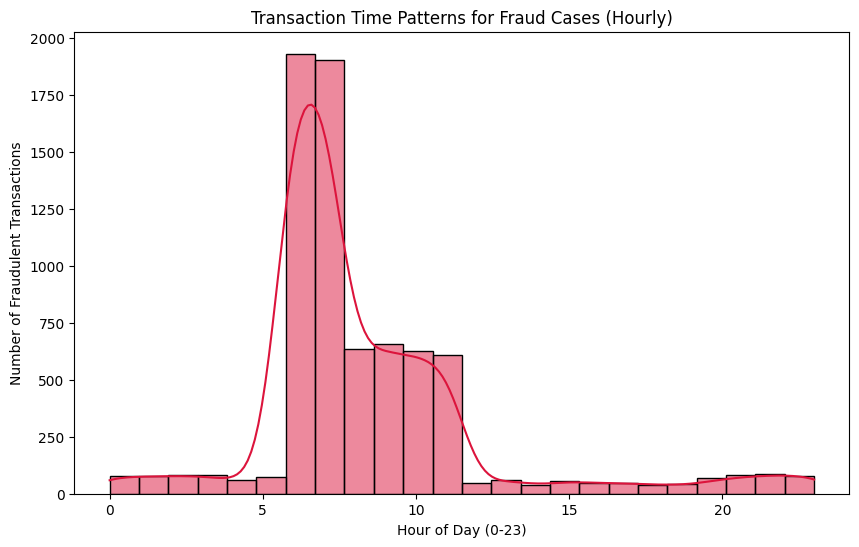

In [ ]:
fraud_df_pandas['trans_date_trans_time'] = pd.to_datetime(fraud_df_pandas['trans_date_trans_time'])
fraud_df_pandas['hour'] = fraud_df_pandas['trans_date_trans_time'].dt.hour

plt.figure(figsize=(10, 6))
sns.histplot(fraud_df_pandas['hour'], bins=24, kde=True, color='crimson')
plt.title('Transaction Time Patterns for Fraud Cases (Hourly)')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

### Step 6e: Normal Distribution of Fraud vs Non-Fraud Cases  

#### Why Normal Distribution?  
Due to the overwhelming number of non-fraudulent transactions, visualizing all data points directly would clutter the plot. Instead, we use the **normal distribution curves** to summarize the patterns, making it easier to compare the fraud and non-fraud distributions.  

#### Steps:  

1. **Calculate Mean and Standard Deviation:**  
   - The dataset is filtered to separate fraud and non-fraud cases.  
   - For each group, the `mean` and `stddev` (standard deviation) of the transaction amounts (`amt`) are calculated using PySpark’s `agg()` function.  
   - These statistics help define the shape of the normal distribution curves.  

2. **Extract Values:**  
   - The computed means and standard deviations for both fraud and non-fraud cases are extracted into Python variables for plotting.  

3. **Generate X-Axis Range:**  
   - The x-axis represents transaction amounts.  
   - The range is set from **0** to the maximum of **(mean + 3 × standard deviation)** for both fraud and non-fraud cases, covering most data points under the normal distribution.  

4. **Plot Normal Distributions:**  
   - `norm.pdf()` is used to compute the probability density function for both distributions.  
   - The fraud distribution is plotted in **red**, while the non-fraud distribution is plotted in **blue** for clear distinction.  

5. **Interpretation:**  
   - The plot shows the transaction amount patterns for fraudulent and non-fraudulent cases.  
   - Any notable differences in their shapes, peaks, or spread can hint at typical fraudulent transaction sizes and help refine fraud detection thresholds.  

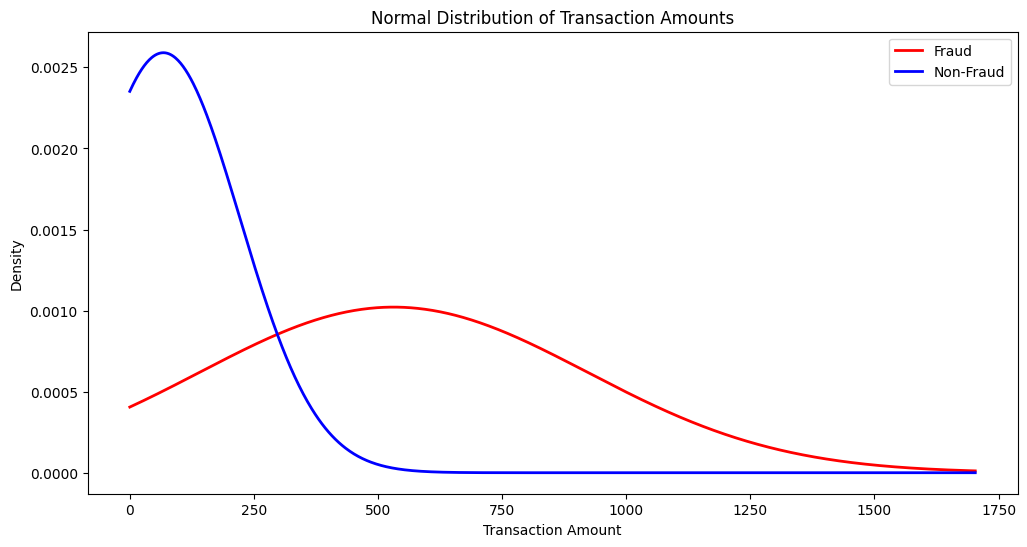

In [23]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Calculate mean and std for fraud and non-fraud cases
fraud_stats = df.filter(df['is_fraud'] == 1).agg(F.mean('amt').alias('mean'), F.stddev('amt').alias('std')).collect()[0]
non_fraud_stats = df.filter(df['is_fraud'] == 0).agg(F.mean('amt').alias('mean'), F.stddev('amt').alias('std')).collect()[0]

# Extract values
fraud_mean, fraud_std = fraud_stats['mean'], fraud_stats['std']
non_fraud_mean, non_fraud_std = non_fraud_stats['mean'], non_fraud_stats['std']

# Generate x-axis range
x = np.linspace(0, max(fraud_mean + 3 * fraud_std, non_fraud_mean + 3 * non_fraud_std), 1000)

# Plot normal distributions
plt.figure(figsize=(12, 6))
plt.plot(x, norm.pdf(x, fraud_mean, fraud_std), color='red', label='Fraud', lw=2)
plt.plot(x, norm.pdf(x, non_fraud_mean, non_fraud_std), color='blue', label='Non-Fraud', lw=2)

plt.title('Normal Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Density')
plt.legend()
plt.show()